# EDA: Анализ биосигналов и курения
  Набор содержит 55692 строк и 27 столбцов  
  


In [28]:
# Загрузка данных, замена категориальных переменных в числовые

In [25]:
import pandas as pd

# Загрузка
df = pd.read_csv('smoking.csv')

# Удаление дубликатов
df = df.drop_duplicates()

# Категориальные переменные
df['gender'] = df['gender'].map({'M': 1, 'F': 0})
df['oral'] = df['oral'].map({'Y': 1, 'N': 0})
df['tartar'] = df['tartar'].map({'Y': 1, 'N': 0})
df['smoking'] = df['smoking'].astype(int)  # таргет

print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  int64  
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

In [27]:
# Вывод: Пропущенных значений нет, размер данных: 55 692 строки × 27 столбцов.


In [45]:

# Исследуем дисбаланс классов

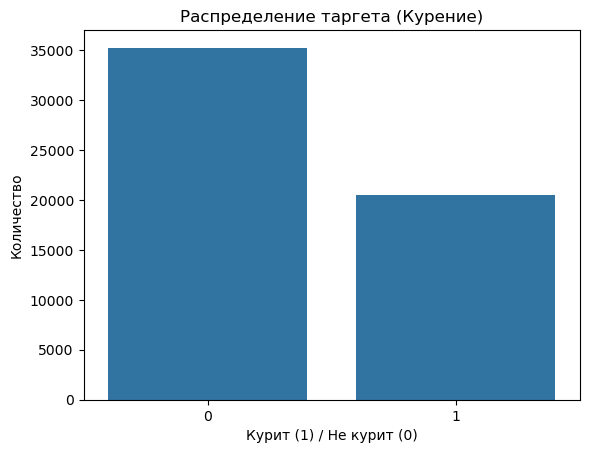

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='smoking', data=df)
plt.title('Распределение таргета (Курение)')
plt.xlabel('Курит (1) / Не курит (0)')
plt.ylabel('Количество')
plt.show()


In [ ]:
# Вывод: присутствует умеренный дисбаланс, 
# его стоит учесть при обучении моделей, чтобы избежать смещения в сторону мажоритарного класса (некурящих).
# Модели могут быть склонны "предсказывать" некурящих чаще, чтобы получить высокую точность.
# Метрики вроде accuracy будут недостаточны — лучше использовать F1-score, precision, recall, AUC-ROC.



In [ ]:

# Распределение курящих по полу

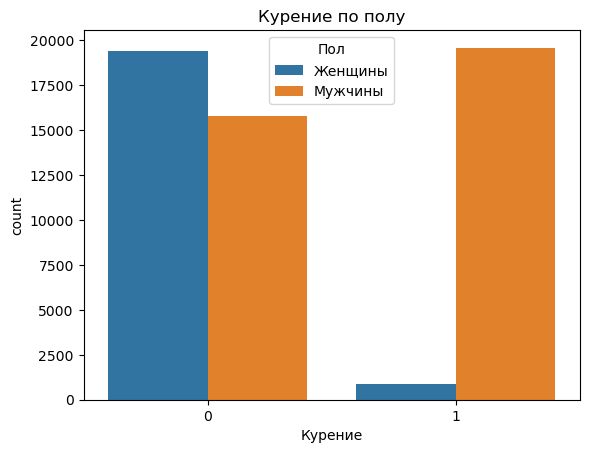

In [27]:
sns.countplot(x='smoking', hue='gender', data=df)
plt.title('Курение по полу')
plt.xlabel('Курение')
plt.legend(title='Пол', labels=['Женщины', 'Мужчины'])
plt.show()


In [46]:
# Вывод: Мужчины курят намного чаще женщин, сильная связь между полом и target


In [47]:

#Корреляция признаков с таргетом

In [28]:
# Только числовые колонки
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Удалим ID из списка
numeric_cols.remove('ID')

# Посчитаем корреляцию с таргетом
correlations = df[numeric_cols].corr()['smoking'].sort_values(ascending=False)

print("Корреляция с таргетом:")
print(correlations)


Корреляция с таргетом:
smoking                1.000000
gender                 0.510340
hemoglobin             0.400678
height(cm)             0.396675
weight(kg)             0.302780
triglyceride           0.251799
Gtp                    0.236619
waist(cm)              0.226259
serum creatinine       0.216812
relaxation             0.108309
dental caries          0.103857
fasting blood sugar    0.100279
tartar                 0.098655
ALT                    0.097338
systolic               0.073109
eyesight(right)        0.063017
eyesight(left)         0.061204
AST                    0.059253
Urine protein          0.014267
hearing(right)        -0.018855
hearing(left)         -0.023209
Cholesterol           -0.028548
LDL                   -0.045220
age                   -0.162557
HDL                   -0.178470
oral                        NaN
Name: smoking, dtype: float64


In [ ]:
# Вывод: сильная корреляция признаков gender - serum creatinine
# oral константа, удалим его 

In [29]:
df = df.drop(columns=['oral'])

In [43]:

# Тепловая карта корреляций

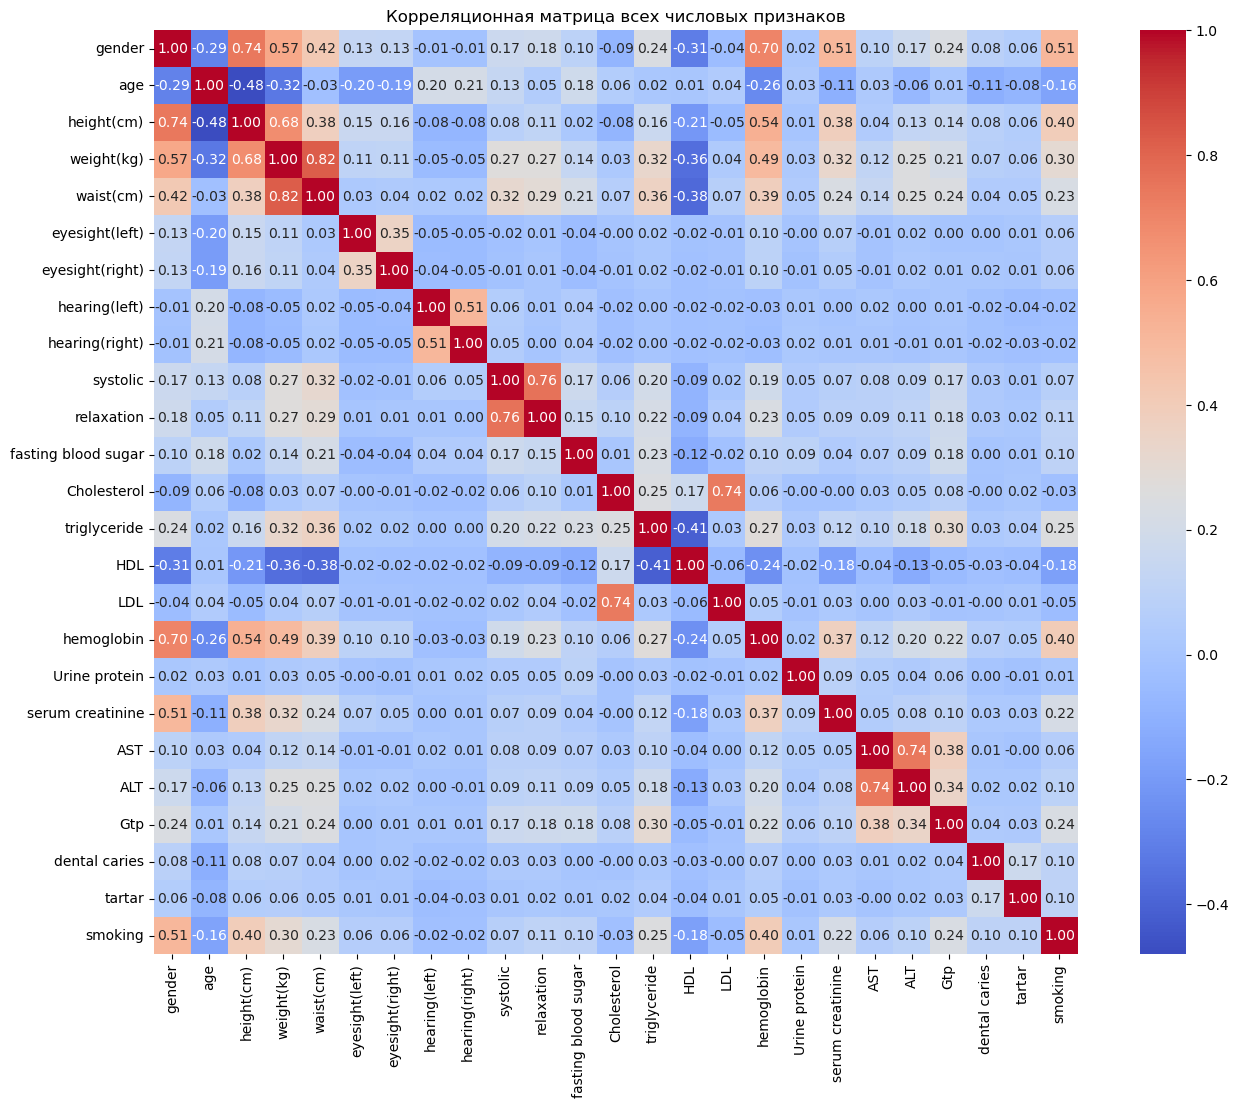

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Выберем только числовые признаки
numeric_df = df.select_dtypes(include='number').drop(columns=['ID'])

# Построим корреляционную матрицу
corr_matrix = numeric_df.corr()

# Построим тепловую карту
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Корреляционная матрица всех числовых признаков")
plt.show()


In [53]:
## Этап 2: Feature Engineering 

In [ ]:
# Создадим новые признаки:
# BMI (индекс массы тела) = вес / рост²

# WHtR (соотношение талии к росту) = талия / рост

# pulse pressure = систолическое - диастолическое давление

In [31]:
# Новые признаки
df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)
df['WHtR'] = df['waist(cm)'] / df['height(cm)']
df['pulse_pressure'] = df['systolic'] - df['relaxation']


In [ ]:
# Посчитаем корреляцию новых признаков с smoking

In [32]:
print(df[['BMI', 'WHtR', 'pulse_pressure', 'smoking']].corr())


                     BMI      WHtR  pulse_pressure   smoking
BMI             1.000000  0.799643        0.155175  0.106967
WHtR            0.799643  1.000000        0.184246  0.029983
pulse_pressure  0.155175  0.184246        1.000000 -0.005450
smoking         0.106967  0.029983       -0.005450  1.000000


In [ ]:
# Вывод: Оставляем BMI — хоть корреляция слабая, деревья могут вытащить информацию из него


In [ ]:

# Удаляем WHtR и pulse_pressure, чтобы не захламлять модель.

In [33]:
df = df.drop(columns=['WHtR', 'pulse_pressure'])


In [34]:
df.head()

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking,BMI
0,0,0,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,0,1,0,24.973985
1,1,0,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,0,1,0,23.437500
2,2,1,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,0,0,1,20.761246
3,3,1,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,0,1,0,25.711662
4,4,0,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,0,0,0,24.973985


In [ ]:

# Feature Importance с помощью модели
#Цель:
#Определить, какие признаки наиболее важны для предсказания smoking
#Используем Random Forest (устойчива к шуму, не требует масштабирования)

C:\Users\anonimus\AppData\Local\Temp\ipykernel_16664\2082279213.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:24], y=feat_imp.index[:24], palette="viridis")


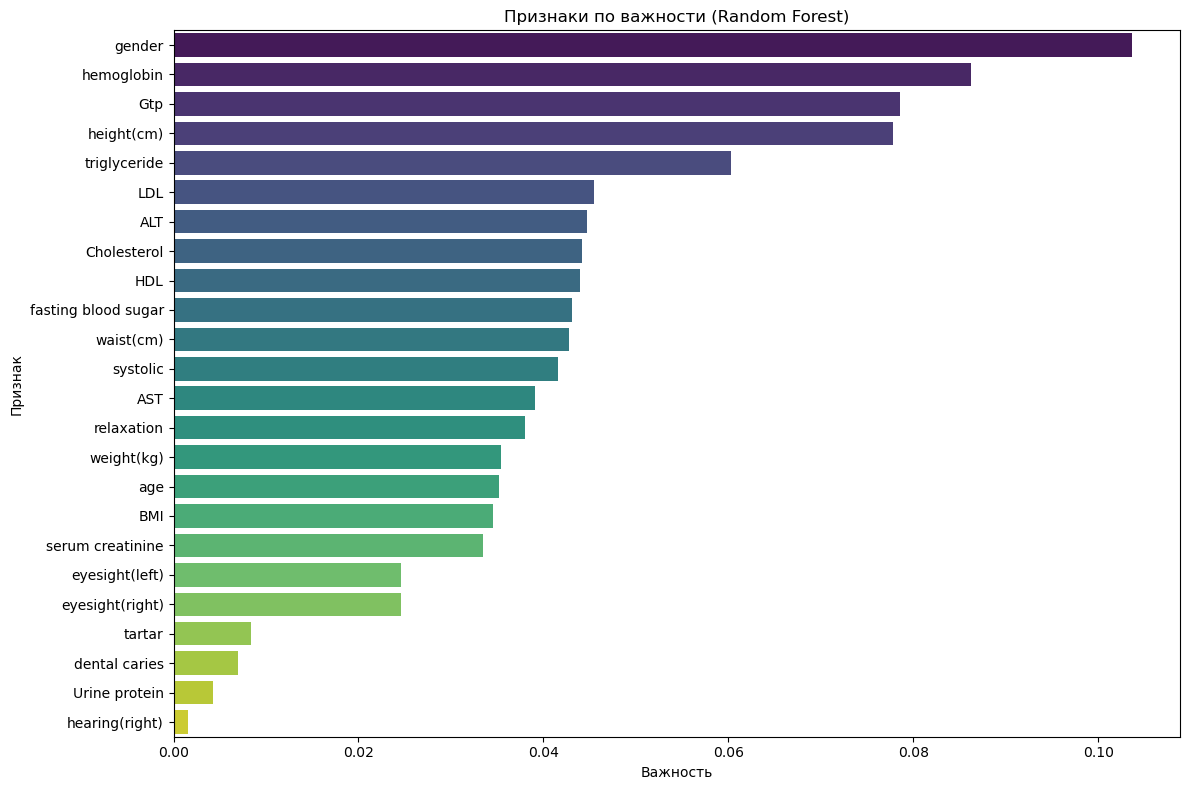

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

data = df.copy()

# Удаляем ID и таргет
X = data.drop(columns=['ID', 'smoking'])

# Таргет
y = data['smoking']

# Перевод категориальных признаков в числовые
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

# Модель
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Важность признаков
importances = model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Визуализация
plt.figure(figsize=(12, 8))
sns.barplot(x=feat_imp.values[:24], y=feat_imp.index[:24], palette="viridis")
plt.title("Признаки по важности (Random Forest)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()


In [36]:
# Таблица важности признаков в числах 
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Отсортируем по убыванию важности
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(feat_imp_df)


                Feature  Importance
0                gender    0.103650
1            hemoglobin    0.086269
2                   Gtp    0.078569
3            height(cm)    0.077852
4          triglyceride    0.060286
5                   LDL    0.045476
6                   ALT    0.044687
7           Cholesterol    0.044193
8                   HDL    0.043937
9   fasting blood sugar    0.043119
10            waist(cm)    0.042801
11             systolic    0.041521
12                  AST    0.039115
13           relaxation    0.038004
14           weight(kg)    0.035426
15                  age    0.035245
16                  BMI    0.034497
17     serum creatinine    0.033460
18       eyesight(left)    0.024643
19      eyesight(right)    0.024590
20               tartar    0.008333
21        dental caries    0.007000
22        Urine protein    0.004216
23       hearing(right)    0.001580
24        hearing(left)    0.001533


In [67]:
# Вывод по важности признаков:
# Всё, что ниже ~0.02 — очень слабый вклад (например, hearing(left/right), Urine protein, tartar, dental caries) - их мы не будем учитывать!
# BMI - 0.0345 (новый нами созданный признак полезен)


In [ ]:

# Оставляем только нужные признаки:

In [37]:
important_features = [
    'gender', 'hemoglobin', 'Gtp', 'height(cm)', 'triglyceride',
    'LDL', 'ALT', 'HDL', 'Cholesterol', 'fasting blood sugar',
    'waist(cm)', 'systolic', 'relaxation', 'weight(kg)',
    'age', 'BMI', 'serum creatinine', 'AST'
]

# Обновляем данные, оставляем только нужные признаки
X_important = df[important_features]


In [38]:
X_important = pd.get_dummies(X_important, drop_first=True)


In [ ]:

#Подготовка таргета и разделение на обучающую и тестовую выборки:

In [39]:
# Таргет
y = df['smoking']

# Разделим на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_important, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)


In [ ]:

### Обучение моделей:

In [ ]:
# Логистическая регрессия (для бинарной классификации)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

logreg = LogisticRegression(max_iter=3000, random_state=42)

# Обучение модели
logreg.fit(X_train, y_train)

# Прогноз на тестовой выборке
y_pred = logreg.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Матрица ошибок
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Подробный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7346

Confusion Matrix:
[[5364 1684]
 [1272 2819]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      7048
           1       0.63      0.69      0.66      4091

    accuracy                           0.73     11139
   macro avg       0.72      0.73      0.72     11139
weighted avg       0.74      0.73      0.74     11139



In [ ]:
# Accuracy = 0.7346
#Модель хорошо предсказывает обе категории, хотя лучше справляется с некурящими — потому что выборка несбалансированная (курящих ~37%).

In [ ]:

#Теперь протестируем дерево решений 

In [41]:
from sklearn.tree import DecisionTreeClassifier

# Инициализация модели
dtree = DecisionTreeClassifier(random_state=42)

# Обучение модели
dtree.fit(X_train, y_train)

# Прогноз на тестовой выборке
y_pred_dtree = dtree.predict(X_test)

# Оценка модели
accuracy_dtree = accuracy_score(y_test, y_pred_dtree)
print(f"\nDecision Tree Accuracy: {accuracy_dtree:.4f}")

# Матрица ошибок
print("\nConfusion Matrix (Decision Tree):")
print(confusion_matrix(y_test, y_pred_dtree))

print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dtree))



Decision Tree Accuracy: 0.7854

Confusion Matrix (Decision Tree):
[[5872 1176]
 [1214 2877]]

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      7048
           1       0.71      0.70      0.71      4091

    accuracy                           0.79     11139
   macro avg       0.77      0.77      0.77     11139
weighted avg       0.79      0.79      0.79     11139



In [ ]:
# Выводы: Модель дерева решений (Decision Tree) показывает себя лучше, чем логистическая регрессия
# Accuracy = 0.7854, лучше по сравнению с Logistic Regression (0.7346)

#Баланс Precision/Recall по сравнению с логистической моделью стал лучше.
#Особенно видно, что качество по курящим (класс 1) выросло (F1-score 0.71 против 0.66).

In [ ]:
# Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Создаём и обучаем модель
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_rf = rf.predict(X_test)

# Оценка качества модели
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Выводим результаты
print("Random Forest - Accuracy:", accuracy_rf)
print("Confusion Matrix (Random Forest):\n", conf_matrix_rf)
print("Classification Report (Random Forest):\n", class_report_rf)


Random Forest - Accuracy: 0.830954304695215
Confusion Matrix (Random Forest):
 [[6046 1002]
 [ 881 3210]]
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.87      0.86      0.87      7048
           1       0.76      0.78      0.77      4091

    accuracy                           0.83     11139
   macro avg       0.82      0.82      0.82     11139
weighted avg       0.83      0.83      0.83     11139



In [ ]:
# Accuracy = 0.8310
#Precision и Recall для класса 0 (некурящих) высокие (0.87 и 0.86).
#Для класса 1 (курящих) метрики тоже неплохие, особенно Recall (0.78), что важно, так как мы стараемся предсказать курящих.

In [ ]:
# XGBoost

In [44]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Создаём и обучаем модель
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_xgb = xgb.predict(X_test)

# Оценка качества модели
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
class_report_xgb = classification_report(y_test, y_pred_xgb)

# Выводим результаты
print("XGBoost - Accuracy:", accuracy_xgb)
print("Confusion Matrix (XGBoost):\n", conf_matrix_xgb)
print("Classification Report (XGBoost):\n", class_report_xgb)


XGBoost - Accuracy: 0.7769997306760033
Confusion Matrix (XGBoost):
 [[5737 1311]
 [1173 2918]]
Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      7048
           1       0.69      0.71      0.70      4091

    accuracy                           0.78     11139
   macro avg       0.76      0.76      0.76     11139
weighted avg       0.78      0.78      0.78     11139



In [ ]:
# Accuracy = 0.7769
#Precision для курящих в XGBoost (0.69) ниже, чем в Random Forest (0.76).
#И Recall для курящих в XGBoost (0.71) ниже, чем у Random Forest (0.78).
#В целом, Random Forest немного лучше по меткам, так как у него более высокие значения precision и f1-score.

In [ ]:
# Нейронная сеть (MLPClassifier)

In [45]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Создаём и обучаем модель
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_mlp = mlp.predict(X_test)

# Оценка качества модели
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
class_report_mlp = classification_report(y_test, y_pred_mlp)

# Выводим результаты
print("Neural Network (MLP) - Accuracy:", accuracy_mlp)
print("Confusion Matrix (Neural Network):\n", conf_matrix_mlp)
print("Classification Report (Neural Network):\n", class_report_mlp)


Neural Network (MLP) - Accuracy: 0.7249304246341682
Confusion Matrix (Neural Network):
 [[4339 2709]
 [ 355 3736]]
Classification Report (Neural Network):
               precision    recall  f1-score   support

           0       0.92      0.62      0.74      7048
           1       0.58      0.91      0.71      4091

    accuracy                           0.72     11139
   macro avg       0.75      0.76      0.72     11139
weighted avg       0.80      0.72      0.73     11139



In [ ]:
# Accuracy = 0.7249
#Precision для курящих в нейронной сети значительно ниже (0.58), чем в других моделях.
#Recall для курящих очень высокий (0.91), но из-за низкой precision, модель склонна делать много ложных срабатываний.
#Accuracy (0.7249) ниже, чем у Random Forest (0.8310) и XGBoost (0.7769).

In [ ]:
# Мы завершили эксперименты с моделями линейной регрессии, деревьями, модификациями градиентного бустинга и нейронной сетью. 
# Результаты показали, что Random Forest продемонстрировал наилучшие показатели точности и сбалансированности метрик.

In [ ]:
#Кросс-валидация на Random Forest

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Создаем модель Random Forest
rf = RandomForestClassifier(random_state=42)

# Настроим StratifiedKFold для кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполним кросс-валидацию
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')

# Печатаем результаты
print("Кросс-валидация - Accuracy для каждого фолда:", cv_scores)
print("Средняя Accuracy по фолдам:", np.mean(cv_scores))


Кросс-валидация - Accuracy для каждого фолда: [0.83104408 0.83032588 0.83444065 0.83300413 0.83022087]
Средняя Accuracy по фолдам: 0.8318071221052004


In [ ]:
# Результаты кросс-валидации показали, что модель Random Forest дает стабильные и высокие результаты с точностью около 83%. 
# Средняя точность по фолдам составляет 83.18%, что указывает на хорошую обобщаемость модели.

In [ ]:
#### Итоговый вывод:

# Random Forest продемонстрировал лучший результат среди всех моделей (по сравнению с линейной регрессией, деревьями и нейронной сетью).
# Кросс-валидация показала, что модель достаточно устойчива и имеет высокую точность.